In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [3]:
!pip install torch

   ---------------------------------------- 0.0/212.5 MB ? eta -:--:--
    --------------------------------------- 2.9/212.5 MB 16.7 MB/s eta 0:00:13
   - -------------------------------------- 8.1/212.5 MB 21.0 MB/s eta 0:00:10
   -- ------------------------------------- 13.6/212.5 MB 23.1 MB/s eta 0:00:09
   --- ------------------------------------ 19.1/212.5 MB 23.7 MB/s eta 0:00:09
   ---- ----------------------------------- 25.7/212.5 MB 25.8 MB/s eta 0:00:08
   ----- ---------------------------------- 31.5/212.5 MB 25.9 MB/s eta 0:00:07
   ------- -------------------------------- 38.0/212.5 MB 27.1 MB/s eta 0:00:07
   -------- ------------------------------- 46.9/212.5 MB 28.4 MB/s eta 0:00:06
   ---------- ----------------------------- 53.2/212.5 MB 29.0 MB/s eta 0:00:06
   ----------- ---------------------------- 61.1/212.5 MB 30.2 MB/s eta 0:00:06
   ------------ --------------------------- 67.9/212.5 MB 30.1 MB/s eta 0:00:05
   ------------- -------------------------- 72.9/21

In [7]:
# Read data
df = pd.read_csv("C:\\Users\\17376\\Desktop\\CYX\\study\\5261 Finance\\61project\\data\\data.csv")
df = df.iloc[:-1]  # Drop last row with NaN
df['date'] = pd.to_datetime(df['date'])

# Drop early rows with missing 'AI'
df = df.dropna()

# Define target and features
target_col = 'boeing'
feature_cols = df.columns.difference(['date', target_col])

# Set index for easier alignment
df = df.set_index('date')


In [9]:
# Standardize target and features separately
target_scaler = StandardScaler()
X_scaler = StandardScaler()

y_scaled = target_scaler.fit_transform(df[[target_col]])
X_scaled = X_scaler.fit_transform(df[feature_cols])

# Convert to numpy arrays
y_scaled = y_scaled.flatten()


In [11]:
def create_sequences(X, y, seq_len):
    xs, ys = [], []
    for i in range(len(X) - seq_len):
        xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(xs), np.array(ys)

seq_len = 30
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_len)


In [13]:
split_idx = int(len(X_seq) * 0.7)

X_train = torch.tensor(X_seq[:split_idx], dtype=torch.float32)
y_train = torch.tensor(y_seq[:split_idx], dtype=torch.float32)

X_test = torch.tensor(X_seq[split_idx:], dtype=torch.float32)
y_test = torch.tensor(y_seq[split_idx:], dtype=torch.float32)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [15]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take last time step
        return out

input_size = X_train.shape[2]
model = LSTMModel(input_size=input_size, hidden_size=64, num_layers=2, output_size=1)


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.unsqueeze(1).to(device)

        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.6f}")


Epoch 20/100, Loss: 0.002408
Epoch 40/100, Loss: 0.002640
Epoch 60/100, Loss: 0.001756
Epoch 80/100, Loss: 0.001726
Epoch 100/100, Loss: 0.001735


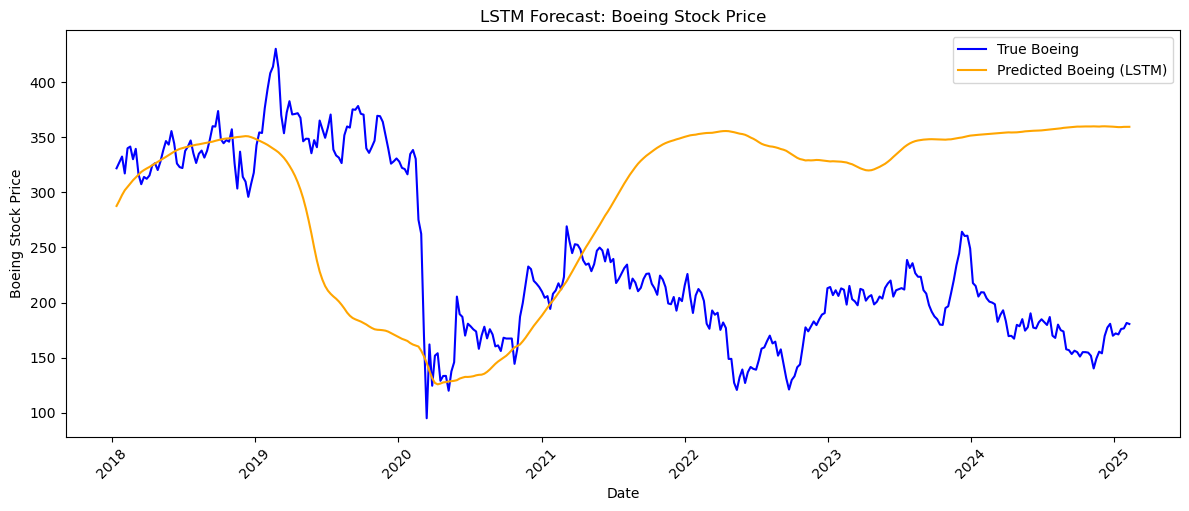

In [21]:
import matplotlib.pyplot as plt

# 1. 模型预测
model.eval()
X_test_device = X_test.to(device)
with torch.no_grad():
    y_pred_lstm = model(X_test_device).cpu().numpy().flatten()  # shape: [n_samples,]

# 2. 反标准化（使用训练阶段的 target_scaler）
y_pred_unscaled = target_scaler.inverse_transform(y_pred_lstm.reshape(-1, 1)).flatten()
y_true_unscaled = target_scaler.inverse_transform(y_test.cpu().numpy().reshape(-1, 1)).flatten()

# 3. 获取对应的测试集日期（注意滑动窗口造成前部数据缺失）
seq_len = 30  # 同前
all_dates = df.index[seq_len:]  # 原始数据起始后的有效时间序列
test_dates = all_dates[split_idx:]  # 测试集部分的日期

# 4. 绘图
plt.figure(figsize=(12, 5))
plt.plot(test_dates, y_true_unscaled, label='True Boeing', color='blue')
plt.plot(test_dates, y_pred_unscaled, label='Predicted Boeing (LSTM)', color='orange')
plt.title('LSTM Forecast: Boeing Stock Price')
plt.xlabel('Date')
plt.ylabel('Boeing Stock Price')
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


In [23]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 建序列
def create_sequences(X, y, seq_len):
    xs, ys = [], []
    for i in range(len(X) - seq_len):
        xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(xs), np.array(ys)

# LSTM 模型定义
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 最后一个时间点输出
        return out


In [25]:
seq_len = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

true_all, pred_all, date_all = [], [], []

for year in range(2005, 2025):
    train_df = df[df.index < f'{year}-01-01']
    test_df = df[(df.index >= f'{year}-01-01') & (df.index < f'{year+1}-01-01')]

    if len(test_df) == 0 or len(train_df) < 100:
        continue

    # 标准化
    y_scaler = StandardScaler()
    X_scaler = StandardScaler()

    y_train_scaled = y_scaler.fit_transform(train_df[['boeing']]).flatten()
    X_train_scaled = X_scaler.fit_transform(train_df.drop(columns='boeing'))

    y_test_scaled = y_scaler.transform(test_df[['boeing']]).flatten()
    X_test_scaled = X_scaler.transform(test_df.drop(columns='boeing'))

    # 创建序列
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

    if len(X_test_seq) == 0:
        continue

    # 转 tensor
    X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)

    # 模型训练
    model = LSTMModel(input_size=X_train_seq.shape[2], hidden_size=64, num_layers=2, output_size=1).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    model.train()
    for epoch in range(30):  # 可自行调节 epoch
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.unsqueeze(1).to(device)
            optimizer.zero_grad()
            loss = criterion(model(X_batch), y_batch)
            loss.backward()
            optimizer.step()

    # 预测
    model.eval()
    with torch.no_grad():
        X_test_tensor = X_test_tensor.to(device)
        y_pred = model(X_test_tensor).cpu().numpy().flatten()

    # 反标准化
    y_pred_inv = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_true_inv = y_scaler.inverse_transform(y_test_tensor.cpu().numpy().reshape(-1, 1)).flatten()
    dates = test_df.index[seq_len:]

    true_all.extend(y_true_inv)
    pred_all.extend(y_pred_inv)
    date_all.extend(dates)


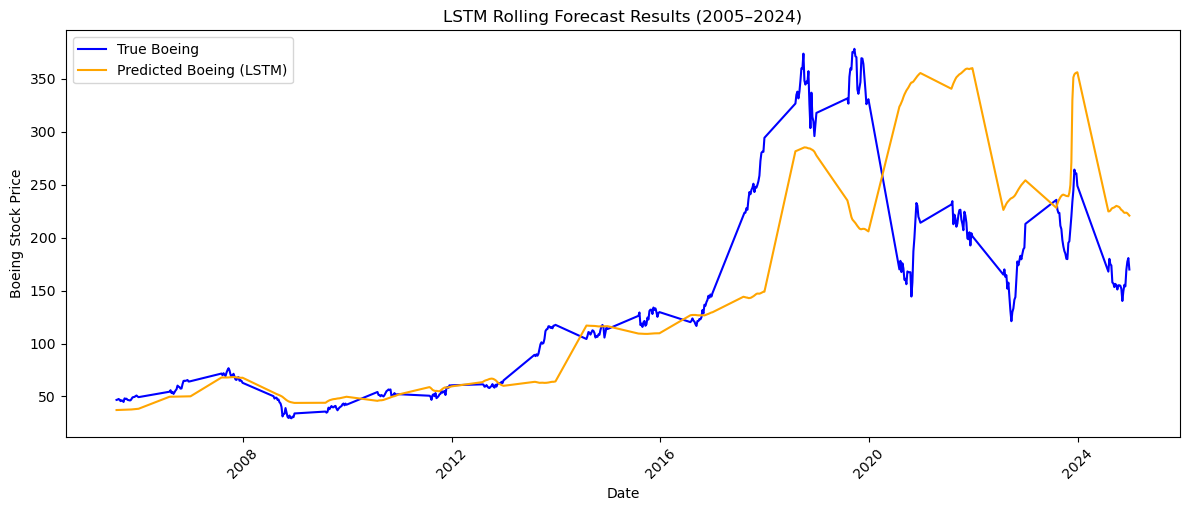

In [27]:
plt.figure(figsize=(12, 5))
plt.plot(date_all, true_all, label='True Boeing', color='blue')
plt.plot(date_all, pred_all, label='Predicted Boeing (LSTM)', color='orange')
plt.title('LSTM Rolling Forecast Results (2005–2024)')
plt.xlabel('Date')
plt.ylabel('Boeing Stock Price')
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(true_all, pred_all)
rmse = mean_squared_error(true_all, pred_all, squared=False)
r2 = r2_score(true_all, pred_all)

print(f"Overall LSTM Rolling Forecast Error:")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.4f}")


Overall LSTM Rolling Forecast Error:
MAE  = 45.66
RMSE = 69.39
R²   = 0.4536


C:\Users\17376\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [31]:
results_lstm = []
start = 0

for year in range(2005, 2025):
    test_df = df[(df.index >= f'{year}-01-01') & (df.index < f'{year+1}-01-01')]
    length = len(test_df) - seq_len

    if length <= 0 or (start + length > len(true_all)):
        continue

    y_true = np.array(true_all[start:start+length])
    y_pred = np.array(pred_all[start:start+length])

    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)

    results_lstm.append({'year': year, 'MAE': mae, 'RMSE': rmse, 'R2': r2})
    start += length  # update window pointer

# 转 DataFrame 看结果
results_lstm_df = pd.DataFrame(results_lstm)
print(results_lstm_df)


    year         MAE        RMSE          R2
0   2005   10.087750   10.172812  -39.090233
1   2006    9.562662   10.500064   -4.523709
2   2007    3.059719    3.753051   -0.131490
3   2008   10.391104   11.411371   -1.299619
4   2009    7.888171    8.017067  -10.439888
5   2010    4.171225    4.973199   -4.637162
6   2011    3.898753    4.820014   -0.443867
7   2012    4.622347    5.258381   -7.080251
8   2013   41.809982   43.192268  -14.617230
9   2014    6.203706    7.137700   -2.874347
10  2015   16.327852   17.283915   -7.872689
11  2016    8.638014   10.018438    0.050758
12  2017  104.279839  105.922760  -26.150093
13  2018   51.707226   55.027615   -6.587445
14  2019  137.916733  139.321350  -61.890968
15  2020  159.103714  160.563705  -36.697689
16  2021  140.192276  141.026413 -165.229691
17  2022   77.853432   80.100998  -11.502545
18  2023   53.899387   62.442417   -4.569630
19  2024   65.220833   66.419022  -35.313297


C:\Users\17376\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\17376\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\17376\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\17376\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

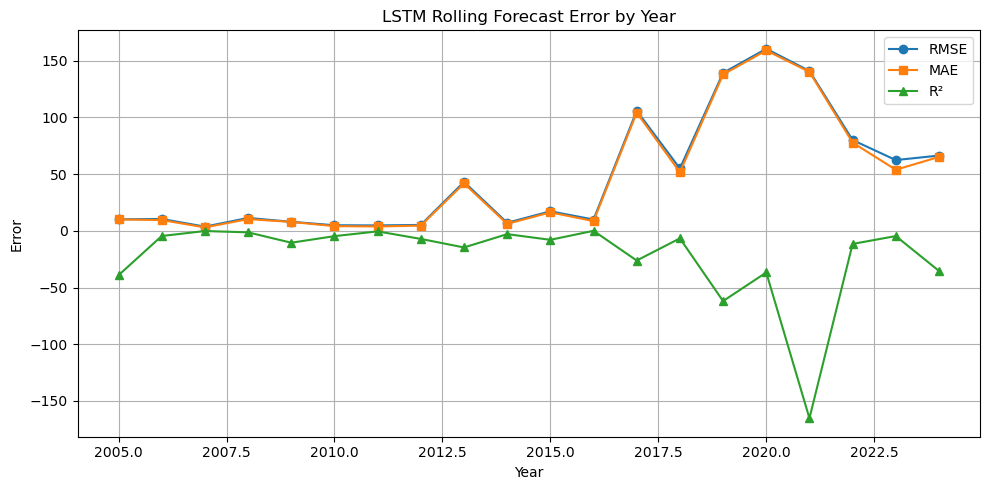

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(results_lstm_df['year'], results_lstm_df['RMSE'], marker='o', label='RMSE')
plt.plot(results_lstm_df['year'], results_lstm_df['MAE'], marker='s', label='MAE')
plt.plot(results_lstm_df['year'], results_lstm_df['R2'], marker='^', label='R²')
plt.title('LSTM Rolling Forecast Error by Year')
plt.xlabel('Year')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


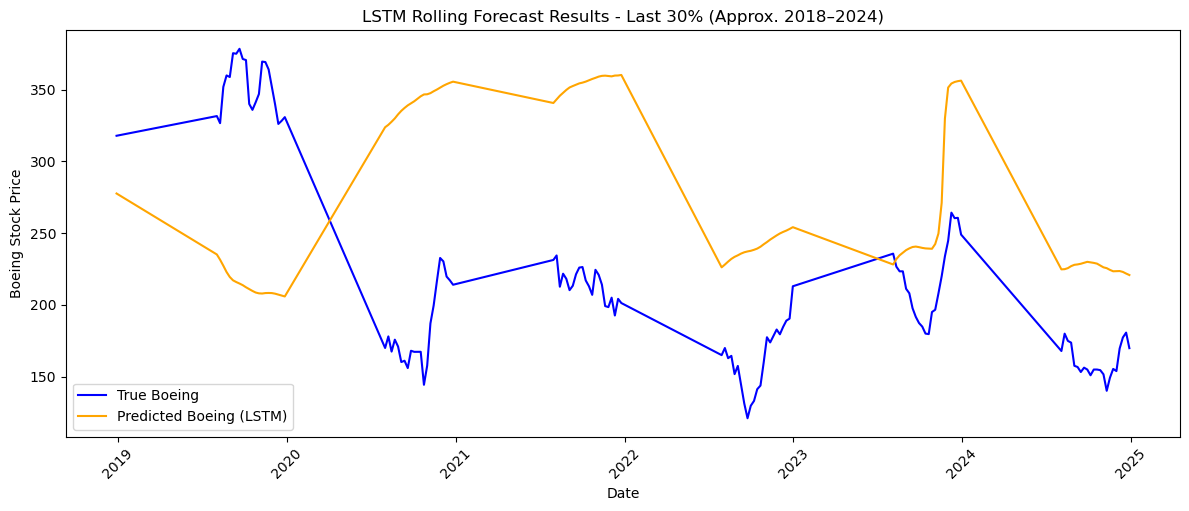

In [35]:
# 计算后 30% 的起始索引
start_idx = int(len(date_all) * 0.7)

# 切片
date_tail = date_all[start_idx:]
true_tail = true_all[start_idx:]
pred_tail = pred_all[start_idx:]

# 绘图
plt.figure(figsize=(12, 5))
plt.plot(date_tail, true_tail, label='True Boeing', color='blue')
plt.plot(date_tail, pred_tail, label='Predicted Boeing (LSTM)', color='orange')
plt.title('LSTM Rolling Forecast Results - Last 30% (Approx. 2018–2024)')
plt.xlabel('Date')
plt.ylabel('Boeing Stock Price')
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()
